## CNN
    
    

In [1]:
 # Define transformations (resize and convert to tensor)

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from torchvision.transforms import v2

transform = v2.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
        v2.RandomHorizontalFlip(p=0.5),  # Randomly flip images
        v2.RandomRotation(10),  # Rotate images by ±10 degrees
        v2.GaussianBlur(kernel_size=3),
        #v2.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Randomly crop and resize image
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

    # Define dataset directories
train_dir = "../data/Training"
test_dir = "../data/Testing"
valid_dir = "../data/Validation"

    # Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform)

    # Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Print class-to-index mapping
print("Class mapping:", train_dataset.class_to_idx)

    # Check a batch of images and labels
images, labels = next(iter(train_loader))
print(f"Batch image shape: {images.shape}")
print(f"Batch labels: {labels}")

    # Checking the label counts
label_counts = Counter(train_dataset.targets)
print("Training class distribution:", label_counts)

label_counts = Counter(test_dataset.targets)
print("Testing class distribution:", label_counts)  

label_counts = Counter(valid_dataset.targets)
print("Validation class distribution:", label_counts)  
    

Class mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Batch image shape: torch.Size([32, 3, 224, 224])
Batch labels: tensor([1, 2, 3, 2, 3, 3, 3, 1, 3, 2, 2, 1, 0, 1, 3, 3, 3, 2, 0, 1, 1, 1, 1, 0,
        1, 1, 3, 2, 2, 0, 1, 0])
Training class distribution: Counter({2: 1595, 3: 1457, 1: 1339, 0: 1321})
Testing class distribution: Counter({2: 203, 1: 153, 0: 150, 3: 150})
Validation class distribution: Counter({2: 202, 1: 153, 0: 150, 3: 150})


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
    def __init__(self):
        
        # this function defines the nn structure
        super().__init__()
        self.cnn_model = nn.Sequential(

            # conv layer 1
            # 1 input as each pixel is level of gray
            nn.Conv2d(in_channels = 3, out_channels=8, kernel_size=3),

            # normalize batch to reduce overfitting
            nn.BatchNorm2d(8),

            #Relu activation, more commonly used than tanh
            nn.ReLU(),

            nn.Dropout(0.3),

            # pool elements
            # might want to do kernel_size of 3
            nn.MaxPool2d(kernel_size = 3, stride = 3),

            # conv layer 2
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size = 3),

             # normalize batch to reduce overfitting
            nn.BatchNorm2d(16),

            #Relu activation, more commonly used than tanh
            nn.ReLU(),

            nn.Dropout(0.3),

            # pool elements
            # might want to do kernel_size of 3
            nn.MaxPool2d(kernel_size = 3, stride = 4),
        )

        self.dense_model = nn.Sequential(
            # adjust in_features based on performance
            # first linear layer
            nn.Linear(in_features=5184, out_features = 512),
            nn.ReLU(),

            # add droput layer to help with overfitting
            nn.Dropout(0.4),

            # second
            #nn.Linear(in_features=128, out_features = 64),
            #nn.ReLU(),
            nn.Linear(in_features=512, out_features = 4),
            # softmax is already applied for cross entropy loss 
        )

    def forward(self, x):
        # this function defines how the information goes through the nn

        # send through cnn
        x = self.cnn_model(x)

        # flatten output
        x = x.view(x.size(0), -1)

        # send through dense 
        x = self.dense_model(x)

        return x

# Get number of classes

# Initialize the model
model = CNN()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class_counts = torch.tensor([826, 822, 395, 827])  # Your class distribution
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()  # Normalize


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

## Testing

In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    model.to(device)  # Ensure model is on the correct device

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Accuracy calculation
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = correct / total * 100
        
        print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

# Train for 25 epochs
train_model(model, train_loader, valid_loader, criterion, optimizer, epochs=25)

Epoch 1, Train Loss: 0.7032, Val Loss: 0.6433, Val Acc: 76.18%
Epoch 2, Train Loss: 0.4275, Val Loss: 0.5631, Val Acc: 76.95%


KeyboardInterrupt: 

In [4]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate the model
evaluate_model(model, test_loader)
evaluate_model(model, train_loader)


Test Accuracy: 90.40%
Test Accuracy: 91.11%


In [5]:
import torch

def calculate_recall_without_sklearn(model, data_loader):
    model.eval()
    true_positives = torch.zeros(4)
    false_negatives = torch.zeros(4)
    
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for i in range(4):
                true_positives[i] += ((predicted == i) & (labels == i)).sum().item()
                false_negatives[i] += ((predicted != i) & (labels == i)).sum().item()
    
    # Compute recall per class
    recall = true_positives / (true_positives + false_negatives)
    recall[torch.isnan(recall)] = 0  # Handle division by zero cases

    # Convert to dictionary
    recall_dict = {f"Class {i}": recall[i].item() for i in range(4)}

    return recall_dict

# Example usage:
recall_rates = calculate_recall_without_sklearn(model, test_loader)
print("Recall per class:", recall_rates)

Recall per class: {'Class 0': 0.9466666579246521, 'Class 1': 0.6339869499206543, 'Class 2': 0.9852216839790344, 'Class 3': 1.0}


In [6]:
def compute_confusion_matrix(model, data_loader):
    model.eval()
    confusion_matrix = torch.zeros(4, 4, dtype=torch.int64)

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t, p] += 1  # Increment the matrix count

    return confusion_matrix

# Example usage:
conf_matrix = compute_confusion_matrix(model, test_loader)
test_conf = compute_confusion_matrix(model, train_loader)

def print_confusion_matrix(conf_matrix, class_names):
    print("\nConfusion Matrix:")
    print(" " * 10, end="")  # Formatting for column headers
    print("  ".join(f"{cls[:5]:>5}" for cls in class_names))  # Print class names as column headers

    for i, row in enumerate(conf_matrix):
        print(f"{class_names[i][:5]:>10} ", end="")  # Row labels
        print("  ".join(f"{val:5}" for val in row.tolist()))  # Print matrix row values

# Example usage:
print_confusion_matrix(conf_matrix, train_dataset.classes)
print_confusion_matrix(test_conf, train_dataset.classes)


Confusion Matrix:
          gliom  menin  notum  pitui
     gliom   145      2      0      3
     menin    27     93     23     10
     notum     0      2    200      1
     pitui     0      0      0    150

Confusion Matrix:
          gliom  menin  notum  pitui
     gliom  1293     16      3      9
     menin   330    886     57     66
     notum     1      5   1584      5
     pitui     0      1      0   1456


## Visualization

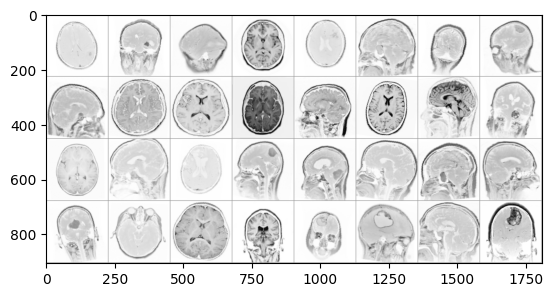

In [23]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# READ ME: Run this code
# Then in the command line enter: pip install tensorflow
# Then enter: cd brain-tumor-classification
# Then enter: tensorboard --logdir=runs --port=6006
# You should then be seeing a localhost site that you can navigate to
# For the next chunk of code, you can just run the code and use the tensorboard run command again


# Function to display images
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Initialize SummaryWriter
writer = SummaryWriter('../runs/brainTumor453_experiment_1')

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid of images
img_grid = torchvision.utils.make_grid(images)

# Show images
matplotlib_imshow(img_grid, one_channel=True)

# Log image to TensorBoard (with step 0)
writer.add_image('brainTumor_images', img_grid, global_step=0)

# Log a dummy scalar to verify logging works
writer.add_scalar('Loss/test', 0.5, 0)

# Close writer to ensure data is written
writer.close()


# Assessing Our Trained Model

In [26]:
class_probs = []
class_label = []
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        output = model(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(train_dataset.classes[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
for i in range(len(train_dataset.classes)):
    add_pr_curve_tensorboard(i, test_probs, test_label)
